In [1]:
import pickle
import random

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.insert(0, "../")
from utils import directed_er_generator, team_maker, motif_adder, degree_maker

# Overview

In [3]:
n1, n2, n3, n4 = 0, 1, 2, 3
n5, n6, n7, n8 = 4, 5, 6, 7
n9, n10, n11 = 8, 9, 10

G = nx.DiGraph()
G.add_edges_from([(n2,n1),(n3,n1),(n4,n1)])   
G.add_edges_from([(n5,n6),(n6,n7),(n7,n8)])
G.add_edges_from([(n9,n10),(n10,n9),(n9,n11)])

In [4]:
motifs = {0:0, 1:0, 2:0, 3:0, 4:1, 5:1, 6:1, 7:1, 8:2, 9:2, 10:2}

In [5]:
# Add team attribute to each node.
nx.set_node_attributes(G, motifs, "motif")  

In [6]:
node_colors = [sns.color_palette("pastel")[motif] for node, motif in motifs.items()]

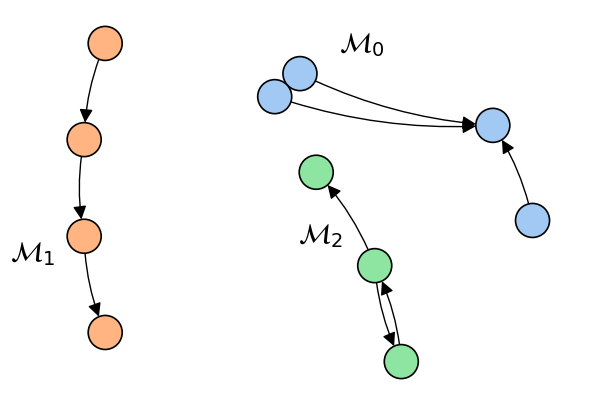

In [7]:
fig, ax = plt.subplots(figsize = (7, 5)) 
ax.axis("off")

nx.draw_kamada_kawai(G, node_color = node_colors, linewidths = 1.2, node_size = 600, connectionstyle = "arc3, rad = 0.1",
                     arrowsize = 20, ax = ax)
ax.collections[0].set_edgecolor("k")

# Motif names.
motif_names = {"$\mathcal{M}_1$": (-0.6, -0.4), "$\mathcal{M}_0$": (0.2, 0.8), "$\mathcal{M}_2$": (0.1, -0.3)}
for m, (x, y) in motif_names.items():
    ax.text(x, y-0.02, m, ha = "center", size = 20) 

fig.savefig("motifs.png", bbox_inches = "tight", dpi = 300)

## TV1

We create several subgraphs by populating them with three different possible motifs/patterns of connections.

These subgraphs want to represent different teams in isolation respect to each other. If a team is created using a particular motif, this means that the connections between some ratio of nodes into the team is connected following the rule of the selected motif.

These subgraphs are linked together by using the Erdos Renyi model.

In [8]:
# Create random directed graph.
G = directed_er_generator(n = 10000, m = 5)

In [9]:
# Remove self-loop.
G.remove_edges_from(nx.selfloop_edges(G))

In [10]:
# Assign each node to a team (no overlapping).
G, teams_composition = team_maker(G)

In [11]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of teams: {len(teams_composition)}")

Number of nodes: 10008
Number of teams: 990


In [12]:
# Add motif structure to each team.
G, teams_label = motif_adder(G, teams_composition)

In [13]:
df = pd.DataFrame(teams_composition.items(), columns = ["team", "members"])
df["label"] = df["team"].map(teams_label)
df.head()

,team,members,label
0,0,"[9065, 836, 3726, 4500, 8681, 6220, 377, 651, ...",0
1,1,"[6047, 610, 9150, 8119, 4726, 7978, 8563, 7699...",0
2,2,"[3558, 8074, 3740, 9298, 4902, 1022, 378, 8853...",0
3,3,"[540, 5354, 158, 8206, 9029, 9108, 8888, 6219,...",0
4,4,"[821, 6590, 406, 8427, 9801, 5498, 7261, 5795]",0


In [14]:
df["label"].value_counts()

label
0    330
1    330
2    330
Name: count, dtype: int64

In [15]:
# Create team composition dictionary: {node_id: [team_id]}.
teams_composition = df.explode("members").groupby("members").apply(lambda x: list(x["team"])).to_dict()

In [16]:
# Add team attribute to each node.
nx.set_node_attributes(G, teams_composition, "Team")  

In [17]:
# Save networkx graph.
with open(f"./tv1/data/graph.pkl", "wb") as f:
    pickle.dump(nx.readwrite.json_graph.node_link_data(G), f)
    
# Save teams label.
with open(f"./tv1/data/teams_label.pkl", "wb") as out:
    pickle.dump(teams_label, out)

## TV2

We create several subgraphs by populating them with three different possible motifs/patterns of connections.

These subgraphs want to represent different teams in isolation respect to each other. If a team is created using a particular motif, this means that the connections between some ratio of nodes into the team is connected following the rule of the selected motif.

These subgraphs are linked together by using the Erdos Renyi model. Furthermore, we add new edges into the network following a preferential attachment method: a member of each team obtains an amount of edges from other nodes of other teams (similar to algorithm of *CIn* synthetic dataset). 

In [18]:
# Create random directed graph.
G = directed_er_generator(n = 10000, m = 1)

In [19]:
# Remove self-loop.
G.remove_edges_from(nx.selfloop_edges(G))

In [20]:
# Assign each node to a team.
G, teams_composition = team_maker(G)

In [21]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of teams: {len(teams_composition)}")

Number of nodes: 10008
Number of teams: 990


In [22]:
# Add motif structure to each team.
G, teams_label = motif_adder(G, teams_composition)

In [23]:
# Add new edges into the network based on pseudo classes.
G, _, _ = degree_maker(G, teams_composition, n_classes = 3, separation = 20, method = "khot", degree = "in", bl = 10, k = 1)

In [24]:
df = pd.DataFrame(teams_composition.items(), columns = ["team", "members"])
df["label"] = df["team"].map(teams_label)
df.head()

,team,members,label
0,0,"[9065, 836, 3726, 4500, 8681, 6220, 377, 651, ...",0
1,1,"[6047, 610, 9150, 8119, 4726, 7978, 8563, 7699...",0
2,2,"[3558, 8074, 3740, 9298, 4902, 1022, 378, 8853...",0
3,3,"[540, 5354, 158, 8206, 9029, 9108, 8888, 6219,...",0
4,4,"[821, 6590, 406, 8427, 9801, 5498, 7261, 5795]",0


In [25]:
# Create team composition dictionary: {node_id: [team_id]}.
teams_composition = df.explode("members").groupby("members").apply(lambda x: list(x["team"])).to_dict()

In [26]:
# Add team attribute to each node.
nx.set_node_attributes(G, teams_composition, "Team")  

In [27]:
# Save networkx graph.
with open(f"./tv2/data/graph.pkl", "wb") as f:
    pickle.dump(nx.readwrite.json_graph.node_link_data(G), f)
    
# Save teams label.
with open(f"./tv2/data/teams_label.pkl", "wb") as out:
    pickle.dump(teams_label, out)

## TV3

We create several subgraphs by populating them with three different possible motifs/patterns of connections.

These subgraphs want to represent different teams in isolation respect to each other. If a team is created using a particular motif, this means that the connections between some ratio of nodes into the team is connected following the rule of the selected motif.

These subgraphs are linked together by using the Erdos Renyi model.

This implementation have nodes that can belong to multiple teams and nodes that not belong to any team.

In [28]:
def team_maker(G, n_teams, min_team_size = 5, poisson_mean = 5, m = 1, seed = 0):    
    """
    This function assigns each node to a corresponding team. No connectivity structure is 
    added by this function.
    
    Parameters:
    -----------        
    G (nx.DiGraph): starting graph.
    n_teams (int): number of teams.
    min_team_size (team_size): minimum team dimension.     
    poisson_mean (int): mean of the random part of the team size. 
    m (int): number of possible random edges add to each new possible node created inside this function.

    Returns:
    --------    
    G (nx.DiGraph): the starting graph where could be added new nodes and edges.
    teams_composition (dict): dictionary with structure {team_id: [node_1, node_2, ...]}.
        
    """    
    np.random.seed(seed)
    random.seed(seed)

    # Teams dictionary.
    nodes_belong_to_team = []
    teams_composition = {}   
    for i in range(n_teams):        
        # Select the team size.
        team_size = min_team_size
        team_size += np.random.poisson(poisson_mean)

        # Choose 'team_size' nodes (without replacement) that will belong to this team.
        nodes_to_choice = set(G.nodes()) - set(random.sample(nodes_belong_to_team, k = int(len(nodes_belong_to_team) * 0.8)))
        teams_composition[i] = list(np.random.choice(list(nodes_to_choice), size = team_size, replace = False))
        
        nodes_belong_to_team.extend(teams_composition[i])
    
    return G, teams_composition

In [29]:
# Create random directed graph.
G = directed_er_generator(n = 10000, m = 5)

In [30]:
# Remove self-loop.
G.remove_edges_from(nx.selfloop_edges(G))

In [31]:
# Assign some nodes to a team.
G, teams_composition = team_maker(G, n_teams = 1000)

In [32]:
df = pd.DataFrame(teams_composition.items(), columns = ["team", "members"]).explode("members")
df.head()

,team,members
0,0,9065
0,0,836
0,0,3726
0,0,4500
0,0,8681


In [33]:
nodes_no_belong_to_team = set(G.nodes()) - set(df["members"]) 
overlapping_members = (df["members"].duplicated().sum() / len(df))*100

In [34]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of teams: {len(teams_composition)}")
print(f"Percentage overlapping members: {overlapping_members}")
print(f"Number of nodes that not belong to any team: {len(nodes_no_belong_to_team)}")

Number of nodes: 10000
Number of teams: 1000
Percentage overlapping members: 17.163134746101562
Number of nodes that not belong to any team: 1713


In [35]:
# Add motif structure to each team.
G, teams_label = motif_adder(G, teams_composition)

In [36]:
df["label"] = df["team"].map(teams_label)

In [37]:
# Create team composition dictionary: {node_id: [team_id]}.
teams_composition = df.explode("members").groupby("members").apply(lambda x: list(x["team"])).to_dict()

In [38]:
# Add team attribute to each node.
nx.set_node_attributes(G, teams_composition, "Team")    
nx.set_node_attributes(G, {node: None for node in nodes_no_belong_to_team}, "Team")

In [39]:
# Save networkx graph.
with open(f"./tv3/data/graph.pkl", "wb") as f:
    pickle.dump(nx.readwrite.json_graph.node_link_data(G), f)
    
# Save teams label.
with open(f"./tv3/data/teams_label.pkl", "wb") as out:
    pickle.dump(teams_label, out)